# Women in Data Science 2022 - Final Solution

# Section 1: Notebook set up

## Imports

In [1]:
import random, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from copy import deepcopy
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge, Ridge, RidgeCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    cross_validate,
    cross_val_score,
    LeaveOneGroupOut,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)

from scipy import stats

## Global notebook setup

### Global variables

In [2]:
TRAIN_PATH = "../input/widsdatathon2022/train.csv"
TEST_PATH = "../input/widsdatathon2022/test.csv"
SUBMISSION_PATH = "../output/"
TARGET = "site_eui"
SCORE = "neg_root_mean_squared_error"
SEED = 777

### Display options

In [3]:
pd.options.display.max_rows = 500

# Section 2: Helper functions

In [4]:
def read_data(train_path, test_path):
    """Read in train and test data for a kaggle competition.

    Parameters
    ----------
    train_path : str
        The path to the training data.
    test_path : str
        The path to the test data

    Returns
    -------
    train_df, test_df : pandas DataFrames
        The train and test datasets.
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df


def get_duplicates(df, drop_cols=None):
    """Determine and return the duplicated values in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to check
    drop_cols : str or list of str, optional
        The columns to drop before returning duplicates.

    Returns
    -------
    pandas DataFrame
        A dataframe containing the rows with duplicated values.
    """
    if drop_cols is not None:
        return df[df.drop(columns=drop_cols).duplicated()]
    else:
        return df[df.duplicated()]
    

def remove_duplicates(df, drop_cols=None):
    """Removes the duplicated values in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to check
    drop_cols : str or list of str, optional
        The columns to drop before removing duplicates.
    Returns
    -------
    pandas DataFrame
        A dataframe without duplicated.
    """
    df_clean = df.copy()

    if drop_cols is not None:
        df_clean = df_clean[~df_clean.drop(columns=drop_cols).duplicated()]
    else:
        df_clean = df_clean[~df_clean.duplicated()]
    
    return df_clean.reset_index(drop=True)


def split_building_data(df, groups):
    """Splits the WiDS 2022 dataset based on groups of facility types.

    Parameters
    ----------
    df : pandas DataFrame
        The WiDS train or test dataset.
    groups : dict (key: str, value: set)
        The dictionary of facility types.  The key should be the desired group name.
        The value should be a set containing the facility types in a given group.

    Returns
    -------
    dfs : dict
        A dictionary of pandas DataFrames, one for each group.
    """
    dfs = {}

    for name, group in groups.items():
        group_df = df.query("facility_type in @group")
        dfs[name] = group_df.reset_index(drop=True)

    return dfs


def get_manual_facility_groups():
    """Returns the manual facility groups used in my final WiDS solution.

    Returns
    -------
    The dictionary of facility types.
        The key is group name (first word in facility type).
        The value is a set containing the facility types in a given group.
    """

    facility_groups = {
        "2to4_5plus_Mixed": {
            "2to4_Unit_Building",
            "5plus_Unit_Building",
            "Mixed_Use_Predominantly_Residential",
        },
        "Commercial_Education_Mixed_Industrial_Parking": {
            "Education_College_or_university",
            "Education_Other_classroom",
            "Education_Preschool_or_daycare",
            "Education_Uncategorized",
            "Commercial_Other",
            "Commercial_Unknown",
            "Mixed_Use_Commercial_and_Residential",
            "Mixed_Use_Predominantly_Commercial",
            "Industrial",
            "Parking_Garage",
        },
        "Food_Grocery": {
            "Food_Sales",
            "Food_Service_Other",
            "Food_Service_Restaurant_or_cafeteria",
            "Food_Service_Uncategorized",
            "Grocery_store_or_food_market",
        },
        "Health": {
            "Health_Care_Inpatient",
            "Health_Care_Outpatient_Clinic",
            "Health_Care_Outpatient_Uncategorized",
            "Health_Care_Uncategorized",
        },
        "Laboratory_Data": {"Laboratory", "Data_Center"},
        "Lodging": {
            "Lodging_Dormitory_or_fraternity_sorority",
            "Lodging_Hotel",
            "Lodging_Other",
            "Lodging_Uncategorized",
        },
        "Multifamily": {"Multifamily_Uncategorized"},
        "Office_Nursing": {
            "Office_Bank_or_other_financial",
            "Office_Medical_non_diagnostic",
            "Office_Mixed_use",
            "Office_Uncategorized",
            "Nursing_Home",
        },
        "Public": {
            "Public_Assembly_Drama_theater",
            "Public_Assembly_Entertainment_culture",
            "Public_Assembly_Library",
            "Public_Assembly_Movie_Theater",
            "Public_Assembly_Other",
            "Public_Assembly_Recreation",
            "Public_Assembly_Social_meeting",
            "Public_Assembly_Stadium",
            "Public_Assembly_Uncategorized",
            "Public_Safety_Courthouse",
            "Public_Safety_Fire_or_police_station",
            "Public_Safety_Penitentiary",
            "Public_Safety_Uncategorized",
        },
        "Religious": {"Religious_worship"},
        "Retail": {
            "Retail_Enclosed_mall",
            "Retail_Strip_shopping_mall",
            "Retail_Uncategorized",
            "Retail_Vehicle_dealership_showroom",
        },
        "Warehouse_Service": {
            "Warehouse_Distribution_or_Shipping_center",
            "Warehouse_Nonrefrigerated",
            "Warehouse_Refrigerated",
            "Warehouse_Selfstorage",
            "Warehouse_Uncategorized",
            "Service_Drycleaning_or_Laundry",
            "Service_Uncategorized",
            "Service_Vehicle_service_repair_shop",
        },
    }

    return facility_groups


def count_missing(df):
    """Counts the missing data in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to count the missing data in.

    Returns
    -------
    pandas DataFrame
        A summary of missing data (counts and %)
    """
    missing_df = pd.DataFrame(
        df.isna().sum().sort_values(ascending=False), columns=["count"]
    )
    missing_df["percent"] = missing_df["count"] / df.shape[0]
    return missing_df.query("count != 0")


def iterative_impute(train_df, test_df, model, ct, target, feat_names, seed):
    """Imputes missing data into train and test datasets with a ML model of choice.

    Parameters
    ----------
    train_df : pandas DataFrame
        The training dataset
    test_df : pandas DataFrame
        The test dataset
    model : sklearn estimator
        The machine learning model to use for imputation
    ct : sklearn ColumnTransformer
        The column transformer to perform on the dataset
    target : str
        The target variable (removed before imputation)
    feat_names : list
        Names of features to append to OHE features from column transformer.
    seed : int
        The random seed for imputation.

    Returns
    -------
    train_imp, test_imp
        Train and test datasets with imputed values.
    """
    train_imp = ct.fit_transform(train_df.drop(columns=[target]))
    test_imp = ct.transform(test_df)

    imputer = IterativeImputer(estimator=model, random_state=seed)

    cols = (
        ct.named_transformers_["onehotencoder"].get_feature_names().tolist()
        + feat_names
    )

    train_imp = pd.DataFrame(imputer.fit_transform(train_imp), columns=cols)
    test_imp = pd.DataFrame(imputer.transform(test_imp), columns=cols)

    return train_imp, test_imp


def replace_columns(df, df_imp, columns):
    """Replace columns in a dataframe with columns from another.

    Note: Meant for use with imputed datasets for WiDS 2022.

    Parameters
    ----------
    df : pandas DataFrame
        The original dataframe.
    df_imp : pandas DataFrame
        The imputed dataframe.
    columns : str or list of str
        The columns to replace between dataframes.

    Returns
    -------
    df_replaced : pandas DataFrame
        Dataframe with replaced columns.
        
    """
    df_replaced = df.copy()

    for col in columns:
        df_replaced[col] = df_imp[col]

    return df_replaced


def impute_and_replace(
    train_dfs, test_dfs, model, ct, target, feat_names, replace, seed
):
    """Iteratively impute multiple dataframes.

    Note: Meant for use solely with WiDS 2022 data.  This simple calls
    the `iterative_impute` and `replace_column` functions for each
    individual dataset in my final WiDS solution.  
    """
    train_dfs_imp = {}
    test_dfs_imp = {}

    # iterative imputation
    for (name1, train_df), (name2, test_df) in zip(train_dfs.items(), test_dfs.items()):
        train_imp, test_imp = iterative_impute(
            train_df, test_df, model, ct, target, feat_names, seed
        )
        train_dfs_imp[name1] = train_imp
        test_dfs_imp[name1] = test_imp

    # replace train columns with missing values
    for (name1, df), (name2, imp_df) in zip(train_dfs.items(), train_dfs_imp.items()):
        train_dfs[name1] = replace_columns(df, imp_df, replace)

    # replace test columns with missing values
    for (name1, df), (name2, imp_df) in zip(test_dfs.items(), test_dfs_imp.items()):
        test_dfs[name1] = replace_columns(df, imp_df, replace)

    return train_dfs, test_dfs


def has_feature(df, feat):
    """Adds a boolean feature if a feature exists or now"""
    return df[feat].notna().astype(int)


def group_by_feature(train_df, test_df, group, agg_feat, transform, name):
    """Adds a new aggregated feature based on a categorical variable"""
    train_df_new = train_df.copy()
    test_df_new = test_df.copy()
    
    fill_values = train_df_new.groupby(group).aggregate(transform)[agg_feat].to_dict()
    
    train_df_new[name] = train_df_new[group].map(fill_values)
    test_df_new[name] = test_df_new[group].map(fill_values)
    
    return train_df_new, test_df_new


def bin_days_below_above(df):
    """Bins the days below and above features into 4 bins"""
    df_eng = df.copy()
    
    df_eng["freezing_days"] = df_eng['days_below_0F'] + df_eng['days_below_10F']
    df_eng["cold_days"] = df_eng['days_below_20F'] + df_eng['days_below_30F']
    df_eng["warm_days"] = df_eng['days_above_80F'] + df_eng['days_above_90F']
    df_eng["hot_days"] = df_eng['days_above_100F'] + df_eng['days_above_110F']
    
    return df_eng


def seasonal_temps(df, stat):
    """Add seasonal temps for a given stat (e.g. "avg_temp")"""
    df_eng = df.copy()

    df_eng[f"winter_{stat}"] = (
        df_eng[f"december_{stat}"]
        + df_eng[f"january_{stat}"]
        + df_eng[f"february_{stat}"]
    ) / 3

    df_eng[f"spring_{stat}"] = (
        df_eng[f"march_{stat}"] + df_eng[f"april_{stat}"] + df_eng[f"june_{stat}"]
    ) / 3

    df_eng[f"summer_{stat}"] = (
        df_eng[f"june_{stat}"] + df_eng[f"july_{stat}"] + df_eng[f"august_{stat}"]
    ) / 3
    
    df_eng[f"autumn_{stat}"] = (
        df_eng[f"september_{stat}"]
        + df_eng[f"october_{stat}"]
        + df_eng[f"november_{stat}"]
    ) / 3

    return df_eng


def feature_engineer(train_df, test_df):
    """Feature engineering function for the WiDS 2022 kaggle competition.

    Note: The feature engineering here was done in a "quick and dirty" method
    in pandas, as speed is key in Kaggle competitions.  In real life ML, I would
    not do it this way, but rather, with custom sklearn Transformers, which is
    much cleaner.
    """
    train_df_eng = train_df.copy()
    test_df_eng = test_df.copy()

    # whether or not a building has a fog detector
    train_df_eng["has_fog_detector"] = has_feature(train_df_eng, "days_with_fog")
    test_df_eng["has_fog_detector"] = has_feature(test_df_eng, "days_with_fog")

    # whether or not a building has a wind detector
    train_df_eng["has_wind_detector"] = has_feature(train_df_eng, "max_wind_speed")
    test_df_eng["has_wind_detector"] = has_feature(test_df_eng, "max_wind_speed")

    # bin days above/below temperature
    train_df_eng = bin_days_below_above(train_df_eng)
    test_df_eng = bin_days_below_above(test_df_eng)

    # seasonal avg temps
    train_df_eng = seasonal_temps(train_df_eng, "avg_temp")
    test_df_eng = seasonal_temps(test_df_eng, "avg_temp")

    # aggregate features
    agg_feats = ["energy_star_rating", "floor_area", "ELEVATION"]

    for agg_feat in agg_feats:
        name = "mean_" + agg_feat
        train_df_eng, test_df_eng = group_by_feature(
            train_df_eng, test_df_eng, "facility_type", agg_feat, "mean", name
        )

    # whether or not energy star is better than mean for facility
    train_df_eng["e_star_better_than_mean"] = (
        train_df_eng["energy_star_rating"] > train_df_eng["mean_energy_star_rating"]
    ).astype(int)
    test_df_eng["e_star_better_than_mean"] = (
        test_df_eng["energy_star_rating"] > test_df_eng["mean_energy_star_rating"]
    ).astype(int)

    # total snow and rain
    train_df_eng["snow_rain_inches"] = (
        train_df_eng["snowfall_inches"] + train_df_eng["precipitation_inches"]
    )
    test_df_eng["snow_rain_inches"] = (
        test_df_eng["snowfall_inches"] + test_df_eng["precipitation_inches"]
    )

    # total degree days
    train_df_eng["degree_days"] = (
        train_df_eng["cooling_degree_days"] + train_df_eng["heating_degree_days"]
    )
    test_df_eng["degree_days"] = (
        test_df_eng["cooling_degree_days"] + test_df_eng["heating_degree_days"]
    )

    # floor area interaction with e-star
    train_df_eng["e_star_floor_area"] = (
        train_df_eng["floor_area"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["e_star_floor_area"] = (
        test_df_eng["floor_area"] * test_df_eng["energy_star_rating"] + 1
    )

    # elevation interaction with e-star
    train_df_eng["e_star_elevation"] = (
        train_df_eng["ELEVATION"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["e_star_elevation"] = (
        test_df_eng["ELEVATION"] * test_df_eng["energy_star_rating"] + 1
    )

    # year_built interaction with e-star
    train_df_eng["e_star_year_built"] = (
        train_df_eng["year_built"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["e_star_year_built"] = (
        test_df_eng["year_built"] * test_df_eng["energy_star_rating"] + 1
    )

    # cooling degree days interaction with energy star
    train_df_eng["cooling_e_star"] = (
        train_df_eng["cooling_degree_days"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["cooling_e_star"] = (
        test_df_eng["cooling_degree_days"] * test_df_eng["energy_star_rating"] + 1
    )

    # heating degree days interaction with energy star
    train_df_eng["heating_e_star"] = (
        train_df_eng["heating_degree_days"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["heating_e_star"] = (
        test_df_eng["heating_degree_days"] * test_df_eng["energy_star_rating"] + 1
    )

    # floor area interaction with year built
    train_df_eng["floor_area_year_built"] = (
        train_df_eng["floor_area"] * train_df_eng["year_built"] + 1
    )
    test_df_eng["floor_area_year_built"] = (
        test_df_eng["floor_area"] * test_df_eng["year_built"] + 1
    )

    # concatenated state and facility type and floor area
    train_df_eng["facility_floor"] = (
        train_df_eng["facility_type"] + "_" + train_df_eng["floor_area"].astype(str)
    )
    test_df_eng["facility_floor"] = (
        test_df_eng["facility_type"] + "_" + test_df_eng["floor_area"].astype(str)
    )

    # concatenated state, facility, year built
    train_df_eng["facility_year"] = train_df_eng["facility_type"] + train_df_eng[
        "year_built"
    ].astype(str)
    test_df_eng["facility_year"] = test_df_eng["facility_type"] + test_df_eng[
        "year_built"
    ].astype(str)

    # concatenated state and facility type and floor area and year
    train_df_eng["facility_floor_year"] = (
        train_df_eng["facility_floor"] + "_" + train_df_eng["year_built"].astype(str)
    )
    test_df_eng["facility_floor_year"] = (
        test_df_eng["facility_floor"] + "_" + test_df_eng["year_built"].astype(str)
    )

    # grouped mean site_eui
    groups = ["facility_floor", "facility_year", "facility_floor_year"]

    for group in groups:
        name = "median_" + group + "_site_eui"
        train_df_eng, test_df_eng = group_by_feature(
            train_df_eng, test_df_eng, group, "site_eui", "median", name
        )

    return train_df_eng, test_df_eng


def feature_engineer_multiple(train_dfs, test_dfs):
    """Feature engineer multiple dataframes at once"""
    train_dfs_eng = {}
    test_dfs_eng = {}

    for (name1, train_df), (name2, test_df) in zip(train_dfs.items(), test_dfs.items()):
        assert name1 == name2
        train_dfs_eng[name1], test_dfs_eng[name2] = feature_engineer(train_df, test_df)

    return train_dfs_eng, test_dfs_eng


def create_X_y(dfs, target, group_col=None):
    """Separates each WiDS 2022 dataframe into X and y train sets.

    Parameters
    ----------
    dfs : dict
        A dictionary of pandas DataFrames, one for each group.
    target : str
        The target variable.
    group_col : str, optional
        The columns to use for CV groups, by default None

    Returns
    -------
    X_dfs, y_dfs, groups
        Dictionaries of X and y train sets, and groups.
    """

    X_dfs = {}
    y_dfs = {}
    groups = {}

    for name, df in dfs.items():
        X_dfs[name] = df.drop(columns=target)
        y_dfs[name] = df[target]

        if group_col is not None:
            groups[name] = df[group_col]

    if group_col is not None:
        return X_dfs, y_dfs, groups
    else:
        return X_dfs, y_dfs
    
    
def get_ct_feat_names(ct, other_names):
    """Get the feature names from a ColumnTrasformer and combine
    with other feature names.

    Note: In recent versions of sklearn there is support for this
    without having to create a function.  However, Kaggle was running
    an older version of sklearn in their kernels during this competition,
    hence creation of this function.

    Parameters
    ----------
    ct : sklearn ColumnTransformer
        A fitted sklearn ColumnTransformer.
    other_names : list of str
        The other feature names to append

    Returns
    -------
    names : list of str
        The list of all feature names after a ColumnTransformer
        transforms a dataset.
    """
    names = []
    names += other_names
    return names


def logo_cv_lgb(
    model, X, y, groups, ct, early_stopping_rounds, return_models=True, other_names=None
):
    """Custom cross validation function for the WiDS 2022 Kaggle Competition.

    Parameters
    ----------
    model : lightGBM regressor
        The lgbm regressor model to perform cv with.
    X : pandas DataFrame
        X train set.
    y : pandas DataFrame
        y train set.
    groups : pandas DataFrame
        The leave one group out cv groups.
    ct : sklearn ColumnTransformer
        The column transformer for the dataset.
    early_stopping_rounds : int
        The number of early stopping rounds for lightGBM
    return_models : bool, optional
        Whether or not to return the indivdual lightGBM models, by default True
    other_names : list of str, optional
        Other feature names to append to CT names, by default None

    Returns
    -------
    results, models : pandas DataFrame, dict
        Results dataframe and dictionary of lgbm models.
    """

    models = []
    results = []
    train_scores = []
    val_scores = []
    fold = 0
    logo = LeaveOneGroupOut()

    for t, v in logo.split(X, groups=groups):
        fold += 1

        # to avoid lightgbm not saving new fit model (weird??? might be bug in lgb...)
        current_model = deepcopy(model)

        # train and val sets for current fold
        X_train, y_train = X.iloc[t], y.iloc[t]
        X_val, y_val = X.iloc[v], y.iloc[v]

        # year factors for current folds
        X_train_yf = np.sort(X_train["Year_Factor"].unique())
        X_val_yf = X_val["Year_Factor"].unique()

        # transform train and val sets
        X_train_tsf = ct.fit_transform(X_train)
        X_val_tsf = ct.transform(X_val)

        if other_names is None:
            feature_names = ct.get_feature_names()
        else:
            feature_names = get_ct_feat_names(ct, other_names)

        # fit and score model w/ early stopping
        current_model.fit(
            X_train_tsf,
            y_train,
            eval_set=[(X_val_tsf, y_val)],
            eval_metric=["rmse"],
            feature_name=feature_names,
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)],
        )

        # train/val rmse scores
        train_rmse = mean_squared_error(
            y_true=y_train, y_pred=current_model.predict(X_train_tsf), squared=False
        )

        val_rmse = current_model.best_score_["valid_0"]["rmse"]

        fold_results = {
            "Fold": fold,
            "Train_shape": X_train_tsf.shape,
            "Val_shape": X_val_tsf.shape,
            "Train_years": X_train_yf,
            "Val_years": X_val_yf,
            "Train_RMSE": train_rmse,
            "Val_RMSE": val_rmse,
            "RMSE_spread": train_rmse - val_rmse,
        }

        results.append(fold_results)
        train_scores.append(train_rmse)
        val_scores.append(val_rmse)
        models.append(current_model)

    # mean validation score
    results.append(
        {
            "Fold": "MEAN",
            "Train_shape": "N/A",
            "Val_shape": "N/A",
            "Train_years": "N/A",
            "Val_years": "N/A",
            "Train_RMSE": np.mean(train_scores),
            "Val_RMSE": np.mean(val_scores),
            "RMSE_spread": np.mean(train_scores) - np.mean(val_scores),
        }
    )

    results = pd.DataFrame(results)

    if return_models:
        return results, models
    else:
        return results
    
    
def logo_cv_lgb_all(
    model,
    X_trains,
    y_trains,
    groups,
    ct,
    early_stopping_rounds,
    return_models=True,
    other_names=None,
):
    """Performs CV for each dataset in the WiDS kaggle competition."""
    results = {}
    models = {}

    for (n1, X), (n2, y), (n3, group) in zip(
        X_trains.items(), y_trains.items(), groups.items()
    ):
        assert n1 == n2 == n3
        results[n1], models[n1] = logo_cv_lgb(
            model, X, y, group, ct, early_stopping_rounds, return_models, other_names
        )

    return results, models


def process_cv_results(results):
    """Process cv results for multiple datasets into one dataframe"""
    results_df = pd.DataFrame()

    for name, result in results.items():
        result.insert(0, "facility_group", name)
        results_df = pd.concat([results_df, result])

    return results_df


def train_and_predict(model, X_trains, y_trains, X_tests, ct, target):
    """Train final WiDS models and get predictions.

    Parameters
    ----------
    model : sklearn estimator
        The model to train and predict.
    X_trains : dict
        Dictionary of X train sets.
    y_trains : dict
        Dictionary of y train sets.
    X_tests : dict
        Dictionary of X test sets.
    ct : sklearn ColumnTransformer
        Column transformer with tranformations to perform on data.
    target : str
        The target variable.

    Returns
    -------
    predictions : pandas DataFrame
        Dataframe containing the final predictions.
    """
    predictions = pd.DataFrame()

    for (n1, X_train), (n2, y_train), (n3, X_test) in zip(
        X_trains.items(), y_trains.items(), X_tests.items()
    ):
        assert n1 == n2 == n3

        current_model = deepcopy(model)
        pipe = make_pipeline(ct, current_model)

        pipe.fit(X_train, y_train)

        pred = {"id": X_test["id"], target: pipe.predict(X_test)}

        predictions = pd.concat([predictions, pd.DataFrame(pred)])

    predictions = predictions.sort_values("id")

    return predictions

# Section 3: Data preprocessing

## Read in data

In [5]:
train, test = read_data(TRAIN_PATH, TEST_PATH)

In [6]:
train.shape

(75757, 64)

In [7]:
test.shape

(9705, 63)

## Duplicated data

In [8]:
train_duplicates = get_duplicates(train, ["id"])
test_duplicates = get_duplicates(test, ["id"])

In [9]:
train = remove_duplicates(train, ["id"])

## Separate data by facility

In [10]:
facility_groups = get_manual_facility_groups()

In [11]:
train_dfs = split_building_data(train, facility_groups)
test_dfs = split_building_data(test, facility_groups)

## Missing data

In [12]:
count_missing(train)

,count,percent
days_with_fog,45783,0.604651
direction_peak_wind_speed,41798,0.552022
max_wind_speed,41070,0.542407
direction_max_wind_speed,41070,0.542407
energy_star_rating,26682,0.352386
year_built,1817,0.023997


## Data imputation: `energy_star`, `year_built`

In [13]:
cat_imp = [
    'Year_Factor', 'State_Factor', 'building_class', 'facility_type'
]

num_imp = [
    'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
    'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
    'snowfall_inches', 'snowdepth_inches', 'avg_temp'
]

drop_imp = [
    'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp', 'days_below_30F', 'days_below_20F',
    'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
    'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
    'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
    'id'
]

In [14]:
ct_imp = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_imp),
    ("passthrough", num_imp),
    ("drop", drop_imp)
)

model = Ridge()
replace = ["energy_star_rating", "year_built"]

In [15]:
train_dfs, test_dfs = impute_and_replace(
    train_dfs, test_dfs, model, ct_imp, TARGET, num_imp, replace, SEED
)

# Section 4: Feature Engineering

## New Features: Entire Dataset

In [16]:
train_dfs_eng, test_dfs_eng = feature_engineer_multiple(train_dfs, test_dfs)

# Section 5: Modelling

## Create `X` and `y` datasets

In [17]:
X_trains, y_trains, groups = create_X_y(train_dfs_eng, TARGET, "Year_Factor")
X_tests = test_dfs_eng.copy()

## Column transformer

In [18]:
cat = [
    'building_class', 'facility_type'
]

num = [
    'year_built', 'energy_star_rating', 'ELEVATION', 'floor_area',
    'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
    'snowdepth_inches', 'e_star_floor_area', 'e_star_elevation', 
    'e_star_year_built', 'cooling_e_star', 'heating_e_star', 'floor_area_year_built',
    'median_facility_floor_site_eui', 'median_facility_floor_year_site_eui',
    'median_facility_year_site_eui'
]

passthrough = [
    'has_fog_detector', 'has_wind_detector', 
]

drop = [
    'Year_Factor', 'State_Factor', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp',  'direction_max_wind_speed',
    'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
    'id', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 
    'days_above_80F', 'days_above_90F', 'days_above_100F', 'days_above_110F', 'State_Factor', 'avg_temp',
    'facility_floor', 'facility_floor_year', 'facility_year','snowfall_inches',
    'freezing_days',
    'cold_days', 'warm_days', 'hot_days', 'winter_avg_temp',
    'spring_avg_temp', 'summer_avg_temp', 'autumn_avg_temp',
    'mean_energy_star_rating', 'mean_floor_area', 'mean_ELEVATION', 'e_star_better_than_mean',
    'snow_rain_inches', 'degree_days',
]

assert set(cat + num + passthrough + drop) == set(X_trains[list(X_trains.keys())[0]].columns)

In [19]:
ct = make_column_transformer(
    (StandardScaler(), num),
    ("passthrough", passthrough),
    ("drop", drop + cat),
)

## Cross validation

In [20]:
model = lgb.LGBMRegressor(force_row_wise=True, random_state=SEED,) #device="gpu")
results, models = logo_cv_lgb_all(model, X_trains, y_trains, groups, ct, 5, other_names=num+passthrough)
results_df = process_cv_results(results)

In [21]:
results_df[results_df["Fold"] == "MEAN"]

,facility_group,Fold,Train_shape,Val_shape,Train_years,Val_years,Train_RMSE,Val_RMSE,RMSE_spread
4,2to4_5plus_Mixed,MEAN,N/A,N/A,N/A,N/A,2.345311,4.576989,-2.231678
6,Commercial_Education_Mixed_Industrial_Parking,MEAN,N/A,N/A,N/A,N/A,14.240220,22.232415,-7.992195
6,Food_Grocery,MEAN,N/A,N/A,N/A,N/A,33.300593,53.069380,-19.768787
6,Health,MEAN,N/A,N/A,N/A,N/A,44.794582,59.557944,-14.763362
6,Laboratory_Data,MEAN,N/A,N/A,N/A,N/A,60.847350,64.118377,-3.271027
6,Lodging,MEAN,N/A,N/A,N/A,N/A,19.038378,25.012244,-5.973866
6,Multifamily,MEAN,N/A,N/A,N/A,N/A,16.144048,19.759498,-3.615449
6,Office_Nursing,MEAN,N/A,N/A,N/A,N/A,13.963483,17.183356,-3.219872
6,Public,MEAN,N/A,N/A,N/A,N/A,14.079825,17.269822,-3.189998
6,Religious,MEAN,N/A,N/A,N/A,N/A,7.222921,10.202259,-2.979338


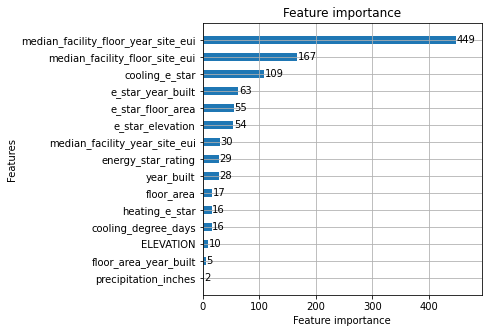

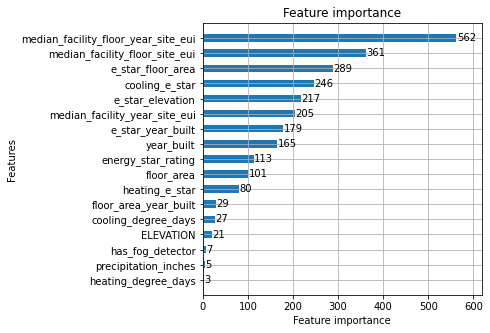

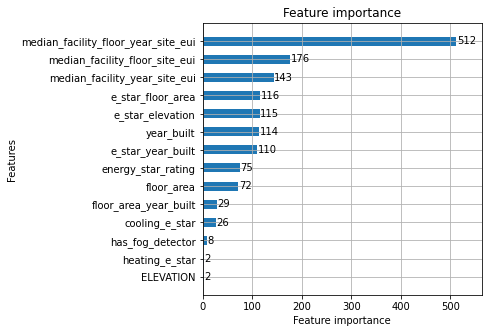

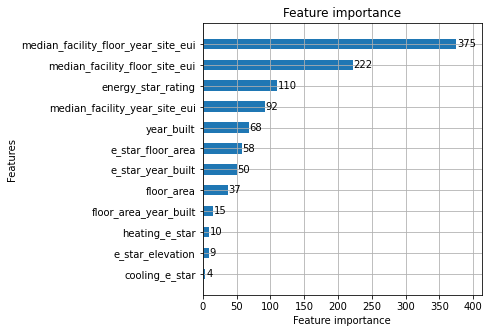

In [22]:
for i in range(len(models["2to4_5plus_Mixed"])):
    lgb.plot_importance(models["2to4_5plus_Mixed"][i], figsize=(5, 5), height=0.5, max_num_features=20);

## Hyperparameter Tuning

# Section 6: Final models and predictions

In [23]:
regressor = VotingRegressor([
    (
        "xgb", 
        xgb.XGBRegressor(
            n_estimators=1000,
            max_depth=8,
            learning_rate=0.15,
            verbosity=0,
            tree_method="gpu_hist",
            random_state=SEED,
        )
    ),
    (
        "lgb",
        lgb.LGBMRegressor(
            force_row_wise=True,
            max_depth=8,
            learning_rate=0.15,
            n_estimators=1000,
            num_leaves=256,
            device="gpu",
            random_state=SEED
        )
    ),
    (
        "cb",
        cb.CatBoostRegressor(
            n_estimators=1000,
            learning_rate=0.15,
            max_depth=8,
            verbose=False,
            random_seed=SEED,
            task_type="GPU"
        )
    )
])

In [24]:
predictions = train_and_predict(regressor, X_trains, y_trains, X_tests, ct, TARGET)

In [25]:
predictions

,id,site_eui
0,75757,155.549032
1,75758,258.077609
2,75759,150.143738
3,75760,264.746211
4,75761,248.344004
...,...,...
1651,85457,25.023604
1652,85458,20.934044
1653,85459,36.901904
1654,85460,28.354291


In [26]:
assert sum(predictions.isna().sum()) == 0

In [27]:
predictions.to_csv("submission.csv", index=False)